<center><h1>Modeling & Prediction</h1></center>  
<center><h6>AI-Powered Price Optimization</h6></center>  

This notebook represents the third stage of our **Airbnb Smart Pricing project** ETL pipeline. Having prepared and cleaned our dataset, we now focus on building a machine learning model that predicts the optimal nightly price for Airbnb listings. The goal is to develop a model that provides pricing recommendations with real business value. These predictions will feed into the final dashboard and business pitch.


In [53]:
# Load necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (LinearRegression, Ridge)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer

In [54]:
# Load preprocessed dataset
airbnb = pd.read_csv("../data/processed/airbnb_preprocessed.csv")
airbnb.head(5)

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,availability_30,review_scores_rating,...,neighbourhood_cleansed_South Kohala,neighbourhood_cleansed_South Kona,neighbourhood_cleansed_Waianae,neighbourhood_cleansed_Wailuku-Kahului,neighbourhood_cleansed_Waimea-Kekaha,amenities_count,avg_price_calendar,availability_ratio,review_count,days_since_last_review
0,-1.894330,1.477264,-1.513788,-0.700078,-0.402413,-1.372894,128.0,0.346509,-0.114232,-0.544188,...,1,0,0,0,0,-0.286168,-0.793186,1.298186,0.479727,-0.552649
1,-0.697677,0.864485,-0.193471,1.019197,-0.402413,-0.260762,211.0,0.945800,0.461307,-1.090219,...,0,0,0,0,0,1.312864,-0.700656,1.161081,2.393720,-0.524304
2,-0.365539,0.679947,-0.193471,-0.700078,-0.402413,-0.260762,259.0,-0.252782,-0.459555,-2.045773,...,0,0,0,0,0,0.913106,-0.238005,0.165822,-0.330039,1.173551
3,1.280089,-1.771513,-0.193471,1.019197,2.224939,1.963500,300.0,-0.852073,-0.229339,-0.612442,...,0,0,0,0,1,-0.019662,-0.083788,-0.053730,2.798603,-0.393918
4,-0.484509,0.827384,-0.193471,-0.700078,0.911263,-0.260762,228.0,2.743672,0.346199,-2.182281,...,0,0,0,1,0,-0.752552,0.403538,1.152195,0.700573,-0.453442


In [55]:
# Define target and features
target = 'price'
X = airbnb.drop(columns=target)
y = airbnb[target]

In [56]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9775, 127)
y_train shape: (9775,)
X_val shape: (1955, 127)
y_val shape: (1955,)
X_test shape: (489, 127)
y_test shape: (489,)


#### Regression Models

In [57]:
# Define models
models = [
    LinearRegression(),
    Ridge(),
    RandomForestRegressor()
]

train_scores = {}
val_scores = {}

# Train and evaluate
for model in tqdm(models, desc="Training models", unit="model"):
    name = model.__class__.__name__
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_scores[name] = {
        'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'R2': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'CV_MAPE': -cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=5).mean()
    }

    val_scores[name] = {
        'MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
        'R2': r2_score(y_val, y_val_pred),
        'MAE': mean_absolute_error(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred))
    }
    

# Convert to DataFrame for comparison
train_scores_df = pd.DataFrame(train_scores).T
val_scores_df = pd.DataFrame(val_scores).T

print("Training Scores:\n", train_scores_df)
print("\nValidation Scores:\n", val_scores_df)

Training models: 100%|████████████████████████████████████████████████████████████████| 3/3 [02:50<00:00, 56.92s/model]

Training Scores:
                            MAPE        R2        MAE       RMSE   CV_MAPE
LinearRegression       0.325574  0.567159  65.582264  90.678118  0.329481
Ridge                  0.325686  0.566368  65.647732  90.760943  0.328787
RandomForestRegressor  0.090717  0.957420  18.759486  28.440726  0.257288

Validation Scores:
                            MAPE        R2        MAE       RMSE
LinearRegression       0.297037  0.568517  67.187932  90.493482
Ridge                  0.296404  0.569634  67.153957  90.376343
RandomForestRegressor  0.232118  0.698220  51.513233  75.679985


The model evaluation results indicate that the Random Forest Regressor significantly outperforms the other models across all metrics. It achieved the lowest training and validation errors, with a training MAPE of 0.09 and validation MAPE of 0.23, along with a high R-squared of 0.96 on training and 0.70 on validation, suggesting strong predictive power, though with some overfitting. In contrast, Ridge Regression performed moderately well, showing slightly better generalization than Linear Regression, with a validation MAPE of 0.296 and R-squared of 0.57. While Ridge offers a balance between performance and interpretability, Linear Regression had the weakest performance across all evaluation metrics. Overall, Random Forest is the most accurate model in this comparison and is recommended if predictive accuracy is the primary goal.

In [64]:
results_df = val_scores_df[['MAPE', 'R2']].rename(columns=lambda x: f"Val_{x}")
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)

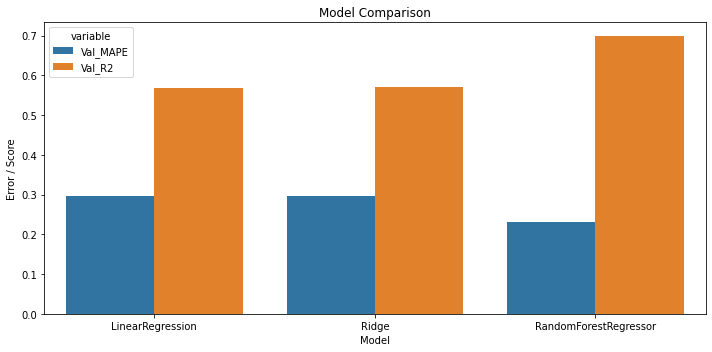

In [65]:
melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
melted['Score'] = melted.groupby('Metric')['Score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison")
plt.ylabel("Error / Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Hyperparameter Tuning

In [59]:
# Define models
models = [
    # LinearRegression(),
    Ridge(),
    RandomForestRegressor(random_state=42)
]

# Define hyperparameter grids
param_grids = {
    # Best Parameters for Ridge: {'alpha': 1.0}
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    },
    # Best Parameters for RandomForestRegressor: 
    # {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3,
    # 'n_estimators': 150}
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, None],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2]
    }
    # LinearRegression has no hyperparameters worth tuning
}

best_scores = {}

# Train and evaluate
for model in tqdm(models, desc="Training models", unit="model"):
    model_name = model.__class__.__name__

    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"\n Best Parameters for {model_name}: {best_params}")
   
    y_train_pred = best_model.predict(X_train)

    best_scores[model_name] = {
        'MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'R2': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
    }

# Convert to DataFrame for comparison
best_scores_df = pd.DataFrame(best_scores).T

print("\n Best Training Scores:\n", best_scores_df)

Training models:   0%|                                                                        | 0/2 [00:00<?, ?model/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Training models:  50%|████████████████████████████████                                | 1/2 [00:20<00:20, 20.30s/model]


 Best Parameters for Ridge: {'alpha': 1.0}
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Best Parameters for RandomForestRegressor: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}


Training models: 100%|███████████████████████████████████████████████████████████████| 2/2 [06:39<00:00, 199.97s/model]


 Best Training Scores:
                            MAPE        R2        MAE       RMSE
Ridge                  0.325686  0.566368  65.647732  90.760943
RandomForestRegressor  0.094829  0.953529  19.325933  29.711854


The hyperparameter tuning process using GridSearchCV significantly improved model performance, especially for the Random Forest Regressor, which achieved optimal results with n_estimators=150, max_depth=None, min_samples_split=3, and min_samples_leaf=1. This configuration led to better training metrics, including a low MAPE of 0.0948 and a high R-squared of 0.95, indicating a very strong fit. In comparison, the Ridge Regression model, optimized with alpha=1.0, yielded a higher MAPE of 0.3257 but lower R² of 0.566.

In [75]:
# Define the best model
models = [
    RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=1, 
                          min_samples_split=3, n_estimators=150)
]

test_scores = {}

# Test and evaluate
for model in tqdm(models, desc="Testing models", unit="model"):
    name = model.__class__.__name__
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    
    test_scores[name] = {
        'MAPE': mean_absolute_percentage_error(y_test, y_test_pred),
        'R2': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }

# Convert to DataFrame for comparison
test_scores_df = pd.DataFrame(test_scores).T

print("Testing Scores:\n", test_scores_df)

Testing models: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:49<00:00, 49.22s/model]

Testing Scores:
                            MAPE        R2        MAE       RMSE
RandomForestRegressor  0.175814  0.720808  50.152099  73.393194


The performance of the tuned Random Forest Regressor on the test set demonstrates strong generalization capability. It achieved a MAPE of 0.1758, indicating that on average, the model's predictions deviate from the actual values by approximately 17.6%. The R² score of 0.721 suggests that over 72% of the variance in the target variable is explained by the model on unseen data, reflecting good predictive strength. Additionally, with a MAE of around 50.15 and an RMSE of 73.39, the model maintains relatively low error margins, affirming its robustness and reliability in estimating prices on new listings.

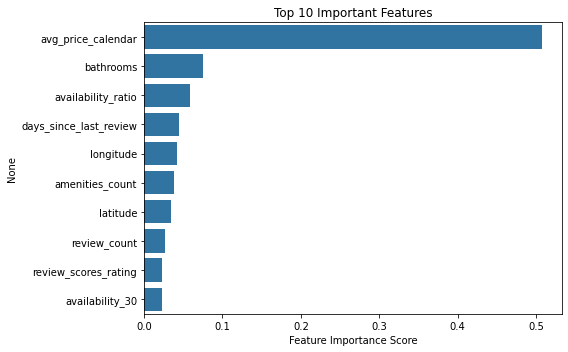

In [73]:
# Choose best model based on R²
best_model = models[0]
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

# Plot the top 10 important features
plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()

In [74]:
# Predicting price for one listing (just as a sample)
sample = X_test.iloc[[9]]
predicted_price = best_model.predict(sample)[0]
print(f"Predicted Price: ${predicted_price:.2f}")

Predicted Price: $378.39
